In [33]:
import numpy as np
import os
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [34]:
def get_folder_files(folder):
    files_cnt = 0
    for sub_folder in os.listdir(folder):
        path, dirs, files = next(os.walk(os.path.join(folder, sub_folder)))
        files_cnt += len(files)
    return files_cnt

In [35]:
train_data_dir = "train_data/train"
validation_data_dir = "train_data/test"

files_train = get_folder_files(train_data_dir)
files_validation = get_folder_files(validation_data_dir)

print(files_train, files_validation)

381 164


In [36]:
img_width, img_height = 48, 48

nb_train_samples = files_train
nb_validation_samples = files_validation

batch_size = 32
epochs = 15
num_classes = 2

In [37]:
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

for layer in model.layers[:10]:
    layer.trainable = False

In [38]:
x = model.output
x = Flatten()(x)

predictions = Dense(num_classes, activation="softmax")(x)
model_final = Model(input = model.input, output = predictions)

model_final.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr = 0.0001, momentum = 0.9), 
                    metrics = ["accuracy"])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [39]:
def gen_image_generator(data_dir):
    data_gen = ImageDataGenerator(
        rescale = 1. / 255,
        horizontal_flip = True,
        fill_mode = "nearest",
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range=0.1,
        rotation_range=5)
    
    image_generator = data_gen.flow_from_directory(
        data_dir,
        target_size = (img_height, img_width),
        batch_size = batch_size,
        class_mode = "categorical")
    
    return image_generator

In [40]:
train_generator = gen_image_generator(train_data_dir)
validation_generator = gen_image_generator(validation_data_dir)

Found 381 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


In [41]:
checkpoint = ModelCheckpoint("carl.h5", monitor='val_acc', 
                             verbose=1, save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

In [42]:
history_object = model_final.fit_generator(
    train_generator, 
    samples_per_epoch = nb_train_samples,
    validation_data = validation_generator,
    nb_val_samples = nb_validation_samples,
    epochs = epochs,
    callbacks = [checkpoint, early])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., epochs=15, callbacks=[<keras.ca..., steps_per_epoch=11, validation_steps=164)`
  import sys


Epoch 1/15
11/11 [==============================] - 70s 6s/step - loss: 0.4671 - acc: 0.7642 - val_loss: 0.4253 - val_acc: 0.7765

Epoch 00001: val_acc improved from -inf to 0.77649, saving model to carl.h5
Epoch 2/15
11/11 [==============================] - 73s 7s/step - loss: 0.3511 - acc: 0.8213 - val_loss: 0.3312 - val_acc: 0.8655

Epoch 00002: val_acc improved from 0.77649 to 0.86554, saving model to carl.h5
Epoch 3/15
11/11 [==============================] - 73s 7s/step - loss: 0.2413 - acc: 0.9310 - val_loss: 0.2620 - val_acc: 0.9059

Epoch 00003: val_acc improved from 0.86554 to 0.90591, saving model to carl.h5
Epoch 4/15
11/11 [==============================] - 81s 7s/step - loss: 0.1786 - acc: 0.9486 - val_loss: 0.2273 - val_acc: 0.9154

Epoch 00004: val_acc improved from 0.90591 to 0.91541, saving model to carl.h5
Epoch 5/15
11/11 [==============================] - 90s 8s/step - loss: 0.1415 - acc: 0.9713 - val_loss: 0.2129 - val_acc: 0.9154

Epoch 00005: val_acc did not imp

In [30]:
import matplotlib.pyplot as plt
print(history_object.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [31]:
def generate_chart(key1, key2, title, ylabel, xlabel):
    plt.plot(history_object.history[key1])
    plt.plot(history_object.history[key2])
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

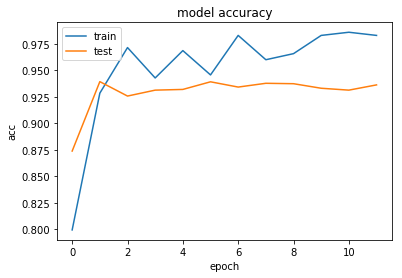

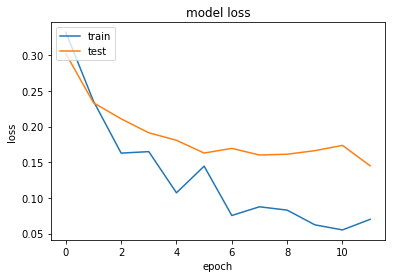

In [32]:
generate_chart('acc', 'val_acc', 'model accuracy', 'acc', 'epoch')
generate_chart('loss', 'val_loss', 'model loss', 'loss', 'epoch')